In [7]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import altair as alt
import seaborn as sns
import pickle
import ast
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
%matplotlib inline 

In [2]:
ALL_LAWS_PATH = 'data/all-votes/laws_20years.csv'
ALL_METRICS_PATH = 'data/all-votes/all_adjacency_metric.csv'
ALL_ADJACENCY_PATH = 'data/all-votes/all_adjacency.pickle'
VOTES_115 = 'data/all-votes/votes_115.csv'
BILLS_115 = 'data/bills/bills_115.csv'
ADJACENCY = 'data/adjacency.csv'

# Learning US senators voting behavior from bills sponsorship profile

This notebook contains the curated content of the Networks Tour of Data Science 2018 final project.

- 1. Exploratory data analysis
    - 1.1 Senates 105 to 115
    - 1.2 Focus on senate 115
- 2. Exploitation
    - 2.1 Graph CNN
    - 
    - 2.3 Transductive Learning

## 1. Exploratory data analysis

In this part we explore the voting patterns of the senates 105 to 115, first looking at similarities and differences between senates and then zooming in on the 115th senate, because this is the most recent one.

### 1.1 Senates 105 to 115

Every senate is active over a period of 2 years. We build the ad

In [3]:
df_metrics = pd.read_csv(ALL_METRICS_PATH)
all_laws = pd.read_csv(ALL_LAWS_PATH)
with open(ALL_ADJACENCY_PATH, 'rb') as handle:
    adjacencies = pickle.load(handle)
    
all_laws['law_id'] = all_laws['vote_uri'].apply(lambda x: '_'.join(x.split('/')[4:]).split('.')[0])
all_laws['q'] = pd.to_datetime(all_laws.date).dt.quarter
all_laws['quarter'] = all_laws.apply(lambda x: '1' '-' + str(x['q']) if x['year'] % 2==0 else '2' + '-' + str(x['q']), axis=1)

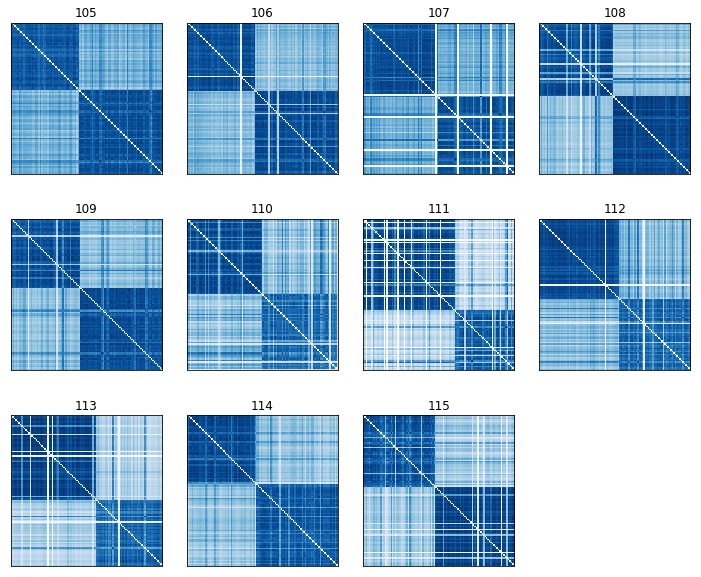

In [4]:
by = 'quarter'
quarters = sorted(all_laws[by].unique())
congress = all_laws['congress'].unique()

f, ax = plt.subplots(3, 4, figsize=(20, 10), squeeze=True )
for i, c in enumerate(congress):
    
    laws = list(all_laws[(all_laws.congress == c)]['law_id'])
    n = len(laws)
    sum_adjacencies = adjacencies[laws[0]]
    for l in laws[1:]:
        sum_adjacencies += adjacencies[l]

    sum_adjacencies /= n

    ax[i//4, i%4].set_title('{}'.format(c))
    ax[i//4, i%4].imshow(sum_adjacencies, cmap = 'Blues')
    ax[i//4, i%4].set_xticks([])
    ax[i//4, i%4].set_yticks([])
f.delaxes(ax[2,3])
plt.subplots_adjust(wspace=-.7, hspace=0.3)
plt.savefig('plots/adj_matrix.pdf', bbox_inches='tight')

In [5]:
for i,j in enumerate(df_metrics['degree_centality']):
    df_metrics['degree_centality'][i] = ast.literal_eval(j)

/Users/mike/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
df_metrics['avg_degree_centrality'] = df_metrics['degree_centality'].apply(lambda x: np.mean(list(x.values())))

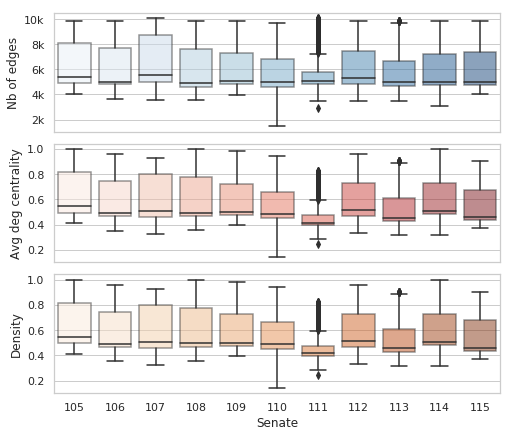

In [9]:
sns.set(style="whitegrid")
f, ax = plt.subplots(3,1, figsize=(8,7))
sns.boxplot(x='congress', y='L', data=df_metrics, boxprops=dict(alpha=.5), ax = ax[0], palette = sns.color_palette("Blues", 11))
sns.boxplot(x='congress', y='avg_degree_centrality', data=df_metrics, boxprops=dict(alpha=.5), ax = ax[1], palette = sns.color_palette("Reds", 11))
sns.boxplot(x='congress', y='density', data=df_metrics, ax = ax[2], boxprops=dict(alpha=.5), palette = sns.color_palette("Oranges", 11))

ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[1].set_xticks([])
ax[1].set_xlabel(None)
ax[2].set_xlabel('Senate')
ax[0].set_ylabel('Nb of edges')
ax[1].set_ylabel('Avg deg centrality')
ax[2].set_ylabel('Density')
ax[0].set_yticklabels(['', '2k', '4k', '6k', '8k', '10k'])
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig('plots/graph_stats.pdf', bbox_inches='tight')

In [12]:
def inside_concordance(yes, no):
    if yes == 0 or no == 0:
        return 1
    else:
        if yes > no:
            return yes / (yes + no)
        else:
            return no / (yes + no)

In [13]:
all_laws['republican_concordance'] = all_laws.apply(lambda x: inside_concordance(x['republican_yes'], x['republican_no']), axis=1)
all_laws['democrats_concordance'] = all_laws.apply(lambda x: inside_concordance(x['democrats_yes'], x['democrats_no']), axis=1)

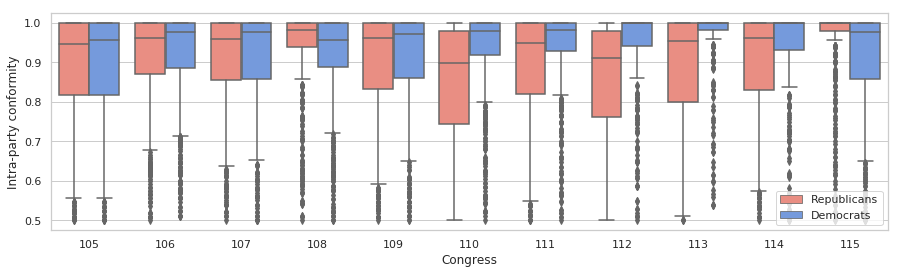

In [15]:
sns.set(style="whitegrid")

r = all_laws[['republican_concordance', 'congress']].rename(columns={'republican_concordance': 'concordance'})
r['party'] = 'republican'
d = all_laws[['democrats_concordance', 'congress']].rename(columns={'democrats_concordance': 'concordance'})
d['party'] = 'democrats'
d = pd.concat([r, d], axis=0)


plt.figure(figsize=(15, 4))
ax = sns.boxplot(x='congress', y='concordance', hue='party', data=d, palette=sns.color_palette(['salmon','cornflowerblue']))
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ['Republicans', 'Democrats'], loc = 'lower right')
plt.xlabel('Congress')
plt.ylabel('Intra-party conformity')
plt.savefig('plots/conform.pdf', bbox_inches='tight')

### 1.2 Senates 115

During we created our models using the senate 115, so here are some indepth numbers about this senate.

In [41]:
all_bills = pd.read_csv(BILLS_115)
votes_115 = pd.read_csv(VOTES_115)
bills_sen = all_bills[all_bills.sponsor_title=='Sen.'] # bills sponsored by senators

N_VOTES = len(votes_115.vote_uri.unique())
N_BILLS = len(all_bills)
N_BILLS_SEN = bills_sen.shape[0]

print('The 115th senate voted {} times in total, whereby {} votes were related to bills. \
Of these bill related votes {} were sponsored by senators. These {} bills are our \
dataset.'.format(N_VOTES, N_BILLS, N_BILLS_SEN, N_BILLS_SEN))

The 115th senate voted 599 times in total, whereby 267 votes were related to bills. Of these bill related votes 79 were sponsored by senators. These 79 bills are our dataset.


In [17]:
members_aux = pd.DataFrame(list(votes_115['member_id'].unique())).rename(columns={0: 'member_id'})
members = members_aux.merge(votes_115.drop_duplicates(subset = 'member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])

N_SENATORS = len(members)
N_DEMS = len(members[members.party == 'D'])
N_REPS = len(members[members.party == 'R'])
N_INDEPS = len(members[members.party == 'I'])

print('There are a total of {} senators in the 115th senate. {} democrats, {} \
republicans and {} who are party independent. This means that the republicans \
have a clear majority.'.format(N_SENATORS, N_DEMS, N_REPS, N_INDEPS))

There are a total of 105 senators in the 115th senate. 48 democrats, 55 republicans and 2 who are party independent. This means that the republicans have a clear majority.
